In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/RANSHUL/PROJECT/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2020 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 1 0 0 1 1 2 2 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0]


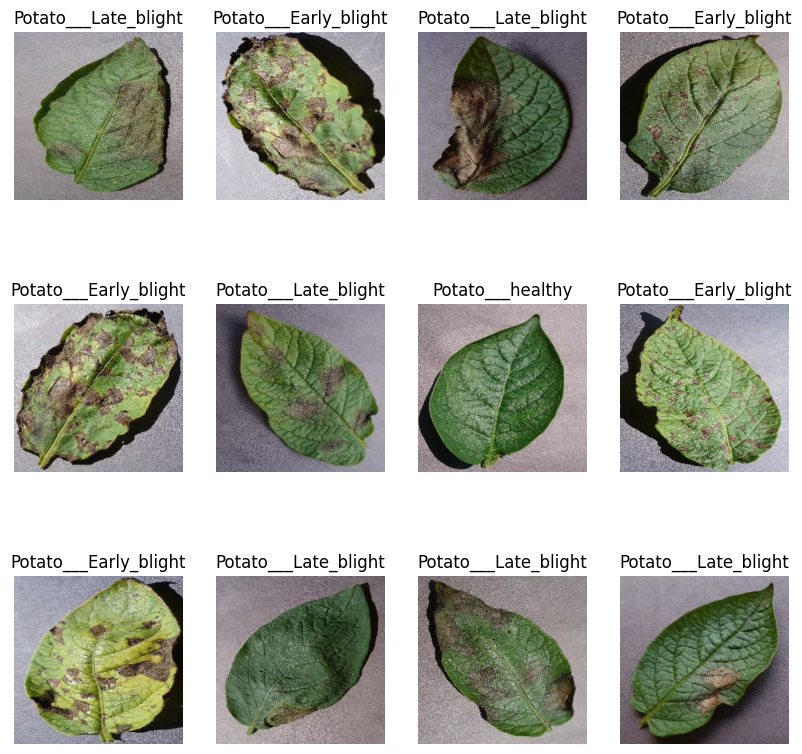

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

64

In [8]:
train_size = 0.8
len(dataset)*train_size

51.2

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

10

In [11]:
val_size=0.1
len(dataset)*val_size

6.4

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

51

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)


7

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [45]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_38 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_39 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (32, 60, 60, 64)        

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
51/51 [==============================] - 48s 903ms/step - loss: 0.9332 - accuracy: 0.4638 - val_loss: 0.8973 - val_accuracy: 0.4792
Epoch 2/25
51/51 [==============================] - 44s 853ms/step - loss: 0.7843 - accuracy: 0.6281 - val_loss: 0.5862 - val_accuracy: 0.8021
Epoch 3/25
51/51 [==============================] - 44s 855ms/step - loss: 0.5844 - accuracy: 0.7763 - val_loss: 0.7008 - val_accuracy: 0.6979
Epoch 4/25
51/51 [==============================] - 45s 876ms/step - loss: 0.5141 - accuracy: 0.8076 - val_loss: 0.6390 - val_accuracy: 0.7448
Epoch 5/25
51/51 [==============================] - 44s 856ms/step - loss: 0.4590 - accuracy: 0.8413 - val_loss: 0.7334 - val_accuracy: 0.7292
Epoch 6/25
51/51 [==============================] - 44s 868ms/step - loss: 0.4618 - accuracy: 0.8168 - val_loss: 0.4496 - val_accuracy: 0.8021
Epoch 7/25
51/51 [==============================] - 45s 880ms/step - loss: 0.4021 - accuracy: 0.8401 - val_loss: 0.6349 - val_accuracy: 0.7812

In [48]:
scores= model.evaluate(test_ds)


7/7 [==============================] - 2s 272ms/step - loss: 0.1791 - accuracy: 0.9375


In [49]:
scores


[0.17906911671161652, 0.9375]

In [50]:
history

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
len(history.history['accuracy'])

25

In [55]:
acc=history.history['accuracy']
val_acc= history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

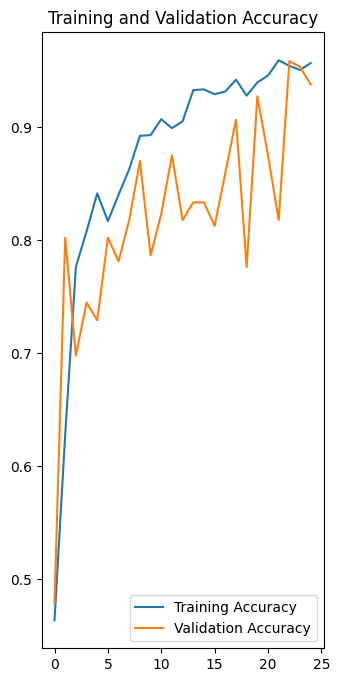

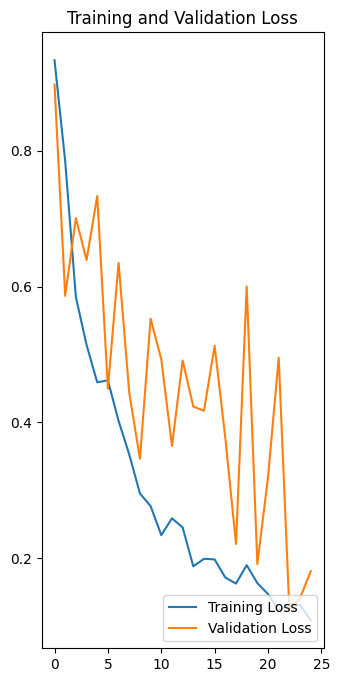

In [58]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

first image to predict
Actual label Potato___Early_blight
1/1 [==============================] - 0s 237ms/step
Potato___Early_blight


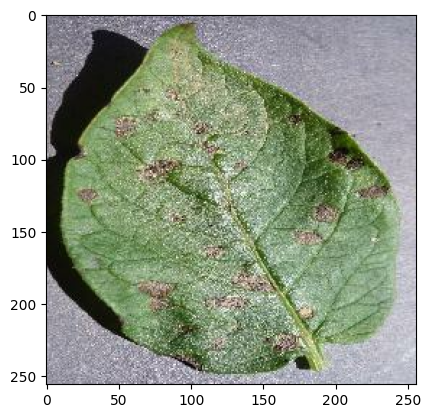

In [75]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('Actual label',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [96]:
def predict(model,img):
    img_array =tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round (100 * (np.max(predictions[0])),2)
    return predicted_class , confidence


1/1 [==============================] - 0s 33ms/step


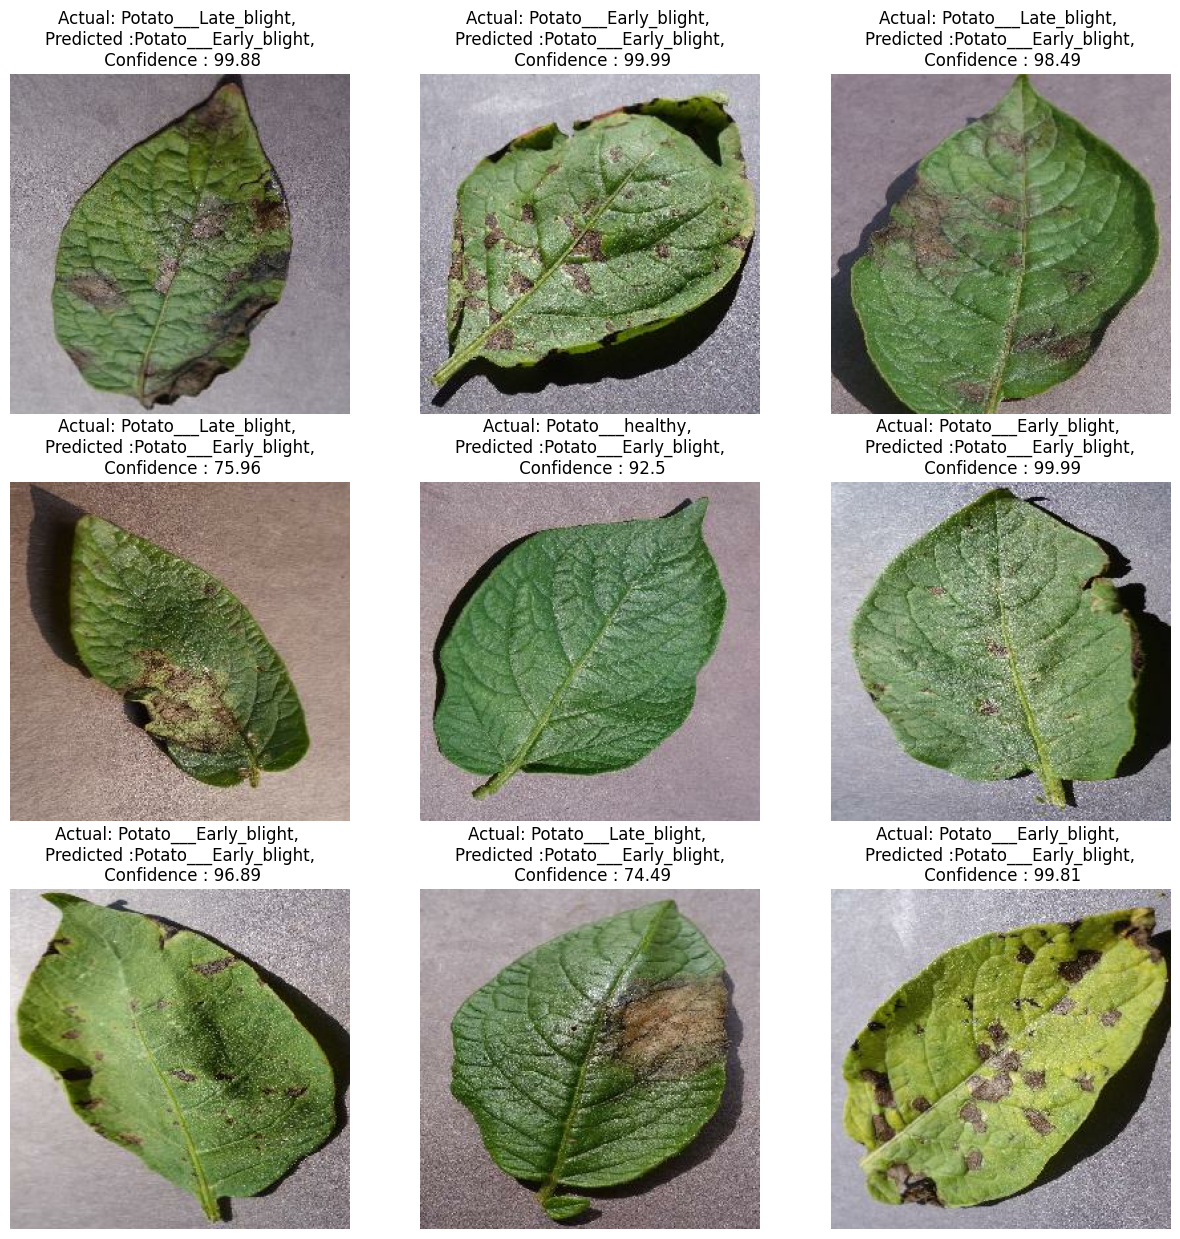

In [97]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())

        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted :{predicted_class},\n Confidence : {confidence}")
        plt.axis('off')

In [100]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
